In [2]:
import numpy as np 
import pandas as pd 
import numpy as np 
import pandas as pd
import xarray as xr
import openpyxl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import *
import matplotlib.colors as colors
from scipy import stats 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point


In [3]:
path ="/Users/andeo/Desktop/Precipitation_Khare_corrected_Nov2016_Nov2023_final.xlsx"
xl_data=pd.ExcelFile(path)
print(xl_data)

In [4]:
dfs = {sheet_name: xl_data.parse(sheet_name) 
       for sheet_name in xl_data.sheet_names}
DataKhare16_23=dfs['Precip_data_Nov16_Nov23']

In [5]:
NameVarsPP16_23=['Time','Tair','u','RH','WMOphase','RRhourly','RRcumul']
UnitVarsPP16_23=['data/hour','(°C)','(ms-1)','(%)','mm','mm']

In [6]:
dfileP16_23= pd.DataFrame(data=DataKhare16_23.loc[10:])

In [7]:
dfP16_23=pd.DataFrame(dfileP16_23.values, columns=NameVarsPP16_23)
Tair_ar=[float(i) for i in dfP16_23.Tair.values]  
RRcumul_ar=[float(i) for i in dfP16_23.RRcumul.values] 
RR=[float(i) for i in dfP16_23.RRhourly.values] 



In [8]:
def NewTime(
        NameVar,
        Var_ar,
        freq):
    start, end = dfP16_23.Time.values[0], dfP16_23.Time.values[-1]
    time = pd.date_range(start, end, freq=freq)
    ds = xr.Dataset({NameVar: ("time",np.asarray(Var_ar)), "time": time})
    print("taille var:",len(Var_ar))  
    print("taille t:",len(time))    
    return ds 

T=NewTime('Tair',Tair_ar,'30min')
RRcumul=NewTime('RRcumul',RRcumul_ar,'30min')
RR=NewTime('RRhourly',RR,'30min')

taille var: 122305
taille t: 122305
taille var: 122305
taille t: 122305
taille var: 122305
taille t: 122305


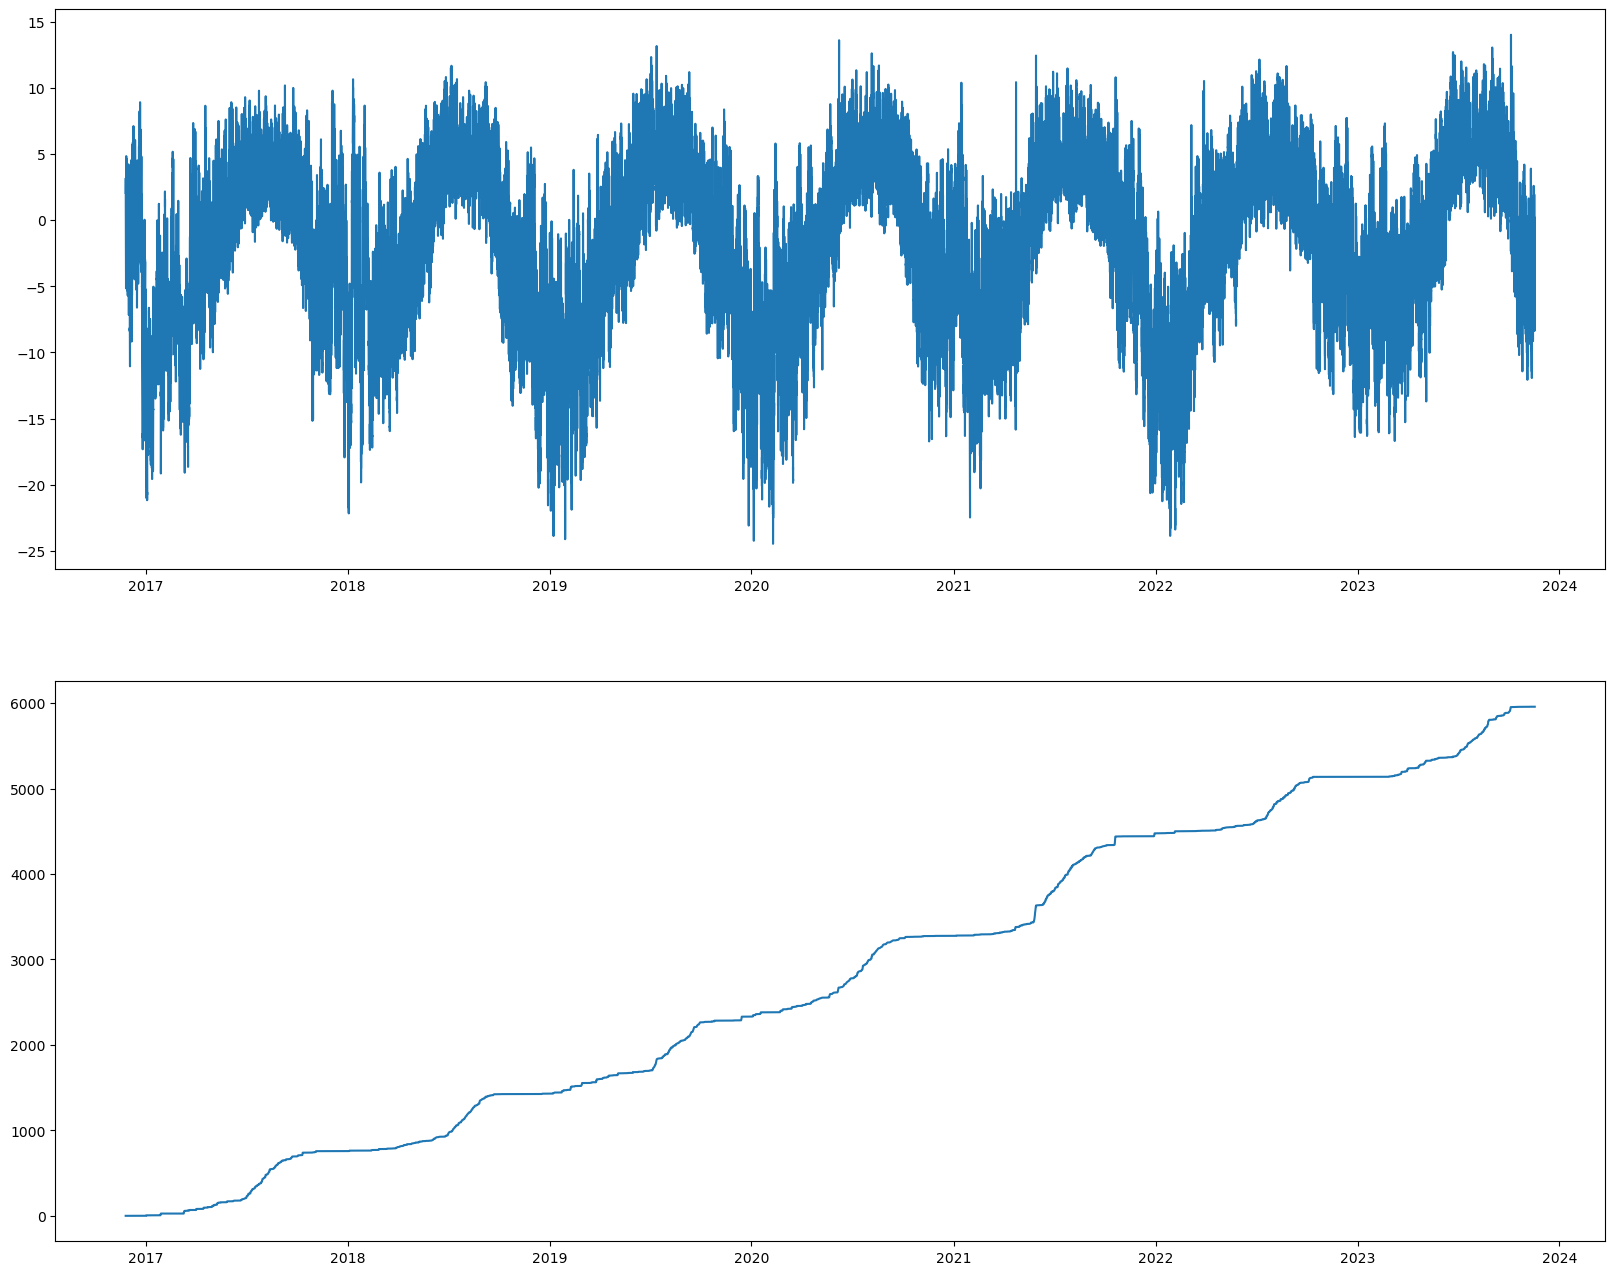

In [9]:
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(20,16))
ax1.plot(T.time, T['Tair'].values)
ax2.plot(RRcumul.time, RRcumul['RRcumul'].values)

In [10]:
#Définition des Saisons, et création d'une fonction qui définit les saisons en fonction des périodes des moussons:
seasons = {
	'MAM': [3, 4, 5],  	
	'JJAS': [6, 7, 8, 9],  
	'ON': [10, 11],    	
	'DJF': [12, 1, 2]  	
}
def seasonsdata(ds, season_name):  #monthly_meanTM.sel(time=monthly_meanTM['time'].dt.month.isin(seasons['MAM'])). Sélectionne dans le dataset les mois correspondants aux saisons définies au dessus

	x = seasons[season_name]
	return ds.sel(time=ds['time'].dt.month.isin(x))


In [11]:
daily_meanRR=RR.resample(time='D').mean()                          #Utilisation de la librairie xarray maintenant possible car les données ont une forme bien définie
monthly_meanRR=daily_meanRR.resample(time='ME').mean()             # chaque variable ici défini est un xarray.Dataset
yearly_meanRR=monthly_meanRR.resample(time='YE').mean()

In [12]:
#monthly_meanRR.time #85

In [13]:
xtime=np.arange(1,85+1,1)
xtime

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85])

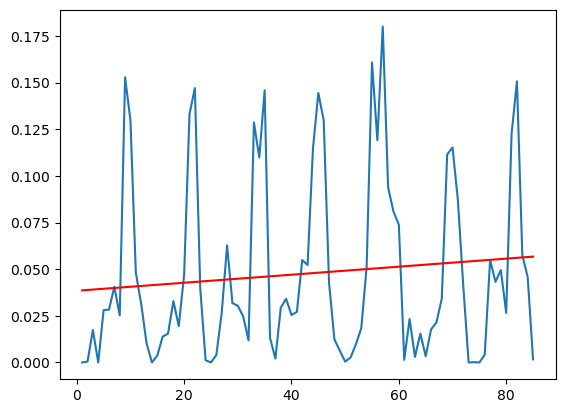

In [14]:
monthly_meanlinregress = stats.linregress(xtime,monthly_meanRR['RRhourly'].values)
monthly_meanlinregress
plt.plot(xtime, monthly_meanRR['RRhourly'].values)
plt.plot(xtime, monthly_meanlinregress.intercept + monthly_meanlinregress.slope*xtime, 'r', label='fitted line')
#Pente négligeable sur cette période MAIS semblent plus bas, s'intéresser/ cibler les saisons et voir sur ces périodes l'évolution? 

In [15]:
RR_premon= seasonsdata(monthly_meanRR, 'MAM').resample(time='YE').mean()
RR_mon =seasonsdata(monthly_meanRR, 'JJAS').resample(time='YE').mean()
RR_postmon=seasonsdata(monthly_meanRR, 'ON').resample(time='YE').mean()
RR_hiver=seasonsdata(monthly_meanRR, 'DJF').resample(time='YE').mean()

In [16]:
RR_premon, RR_mon, RR_postmon, RR_hiver
xtime_premon =np.arange(2016,2022+1,1)
xtime_mon=np.arange(2016,2022+1,1)
xtime_hiver=np.arange(2016,2023+1,1)
xtime=np.arange(2016,2023+1,1)
xtime_postmon= np.arange(2016,2023+1,1)

In [17]:
linRR_mon = stats.linregress(xtime_mon,RR_mon['RRhourly'].values)
linRR_postmon = stats.linregress(xtime_postmon,RR_postmon['RRhourly'].values)
linRR_premon = stats.linregress(xtime_premon,RR_premon['RRhourly'].values)
linRR_hiver = stats.linregress(xtime_hiver,RR_hiver['RRhourly'].values)

In [18]:
linRR_mon,linRR_postmon,linRR_premon,linRR_hiver

(LinregressResult(slope=0.0003878693488913568, intercept=-0.6855993366679296, rvalue=0.0710722129038896, pvalue=0.8796485651855858, stderr=0.00243445064585871, intercept_stderr=4.915158265529151),
 LinregressResult(slope=0.0033034370465014453, intercept=-6.656258261355643, rvalue=0.6250388488388511, pvalue=0.09751094770426233, stderr=0.0016842571864719256, intercept_stderr=3.4013595773217924),
 LinregressResult(slope=0.002918889938740096, intercept=-5.854838120418723, rvalue=0.30329289376401375, pvalue=0.5084648610709026, stderr=0.004101253522004094, intercept_stderr=8.280434923583536),
 LinregressResult(slope=9.641487525178688e-05, intercept=-0.18305397585905922, rvalue=0.01844893291546237, pvalue=0.9654160991526293, stderr=0.0021331590859582955, intercept_stderr=4.307917546828999))

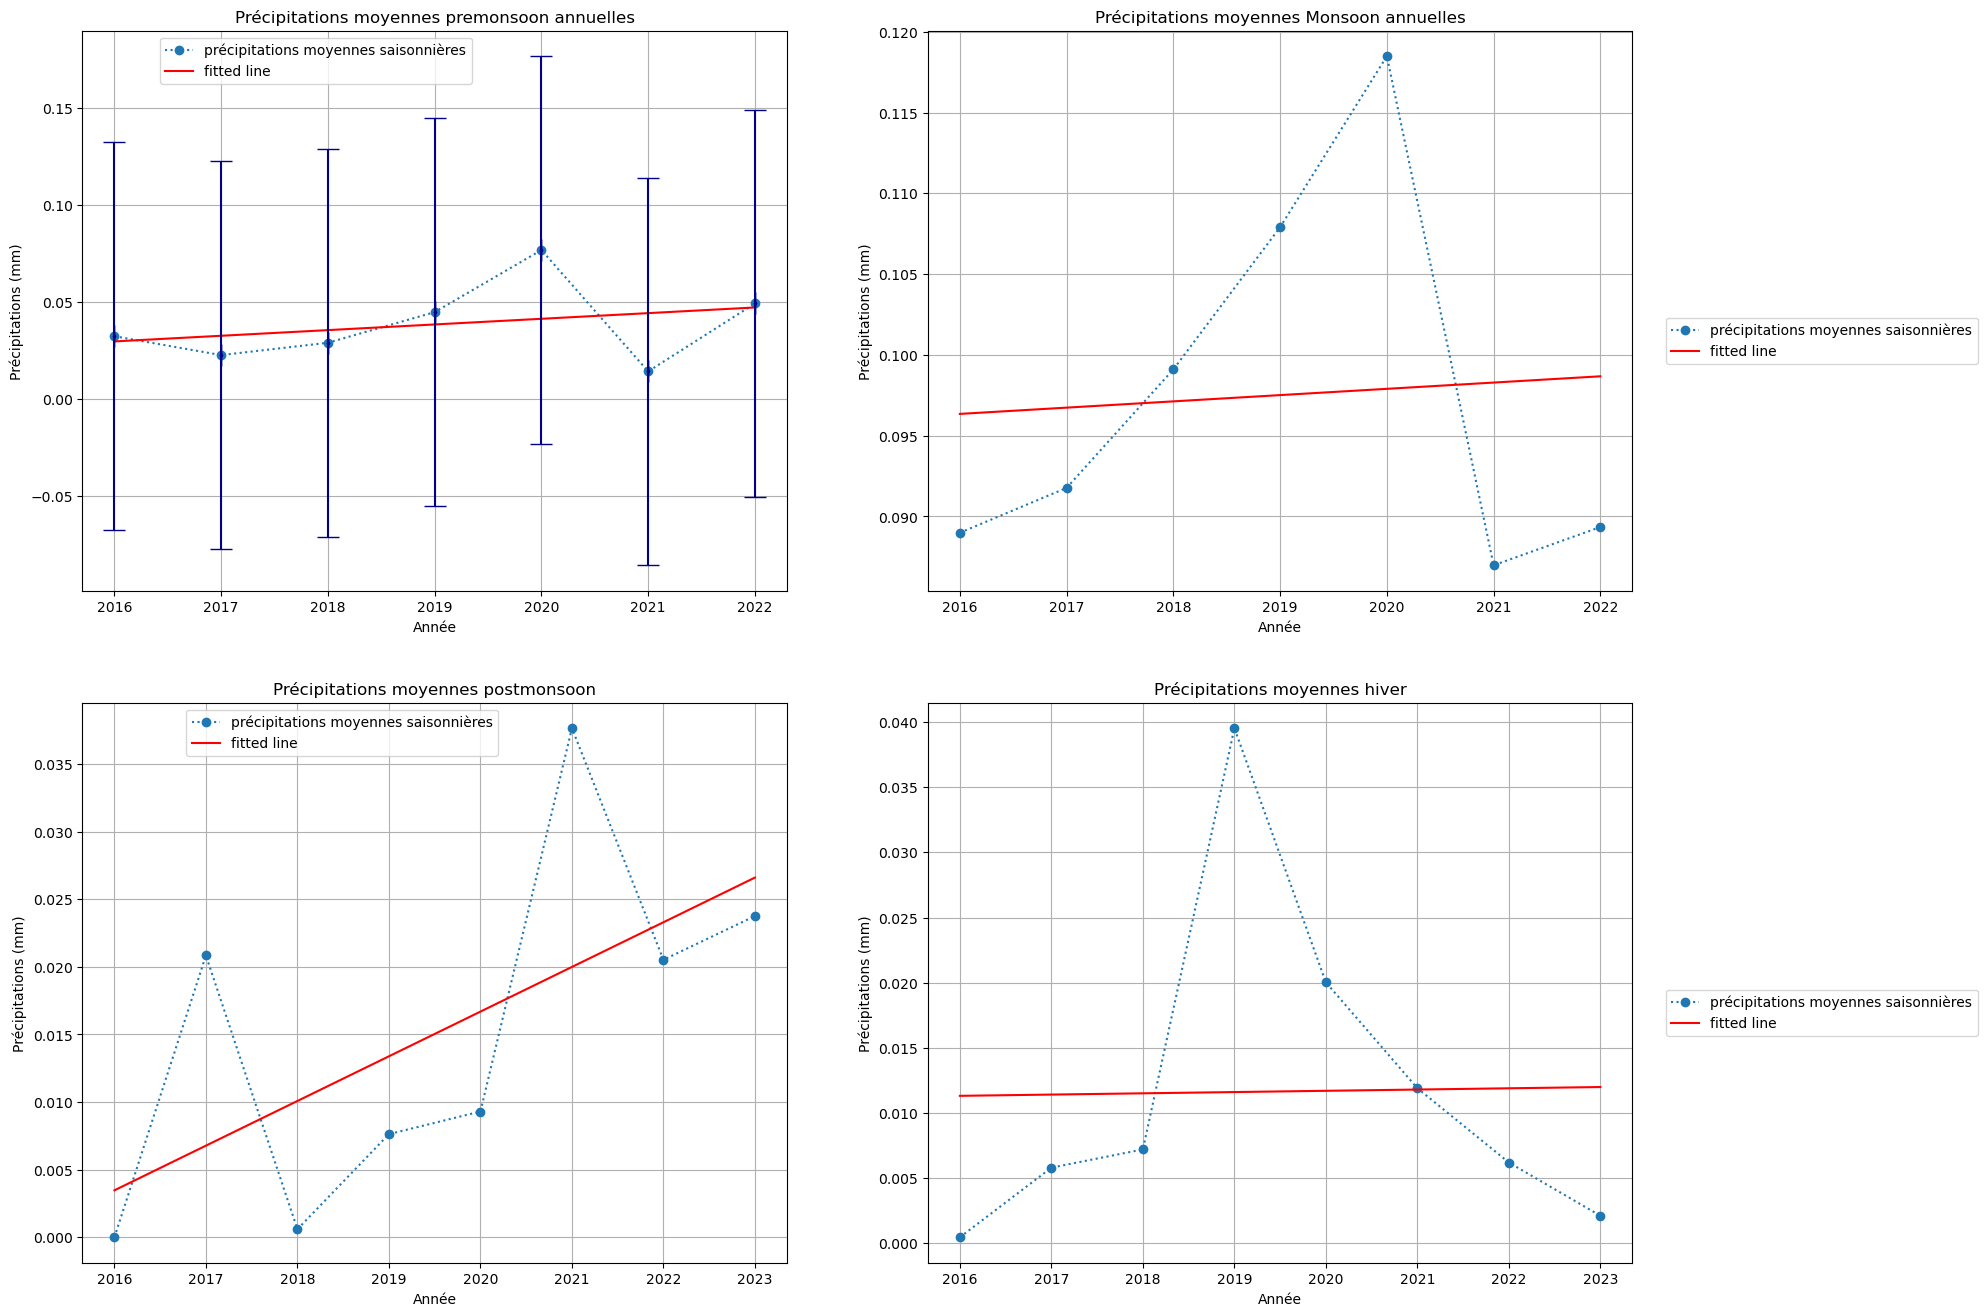

In [19]:
fig, ((ax1,ax2) , (ax3,ax4)) = plt.subplots(2,2, figsize=(20,16))
ax1.plot(xtime_premon, RR_premon['RRhourly'].values, linestyle=':', marker= 'o', label='précipitations moyennes saisonnières')
ax1.plot(xtime_premon, linRR_premon.intercept + linRR_premon.slope*xtime_premon, 'r', label='fitted line')
ax1.errorbar(xtime_premon,RR_premon['RRhourly'].values, xerr=0, yerr=0.1, marker="d",    #not corrected neither for noise nor for undercatch,  +-15%
            markersize=2,
            linestyle="none",
            color="darkblue",
            capsize=8)
ax1.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax1.set_title('Précipitations moyennes premonsoon annuelles')
ax1.set_xlabel('Année')
ax1.set_ylabel('Précipitations (mm)')
ax1.grid()

ax2.plot(xtime_mon, RR_mon['RRhourly'].values,linestyle=':', marker= 'o', label='précipitations moyennes saisonnières')
ax2.plot(xtime_mon, linRR_mon.intercept + linRR_mon.slope*xtime_mon, 'r', label='fitted line')
ax2.legend(bbox_to_anchor=(1, 0, 0.5, 0.5)) 
ax2.set_title('Précipitations moyennes Monsoon annuelles')
ax2.set_xlabel('Année')
ax2.set_ylabel('Précipitations (mm)')
ax2.grid()

ax3.plot(xtime_postmon, RR_postmon['RRhourly'].values,linestyle=':', marker= 'o', label='précipitations moyennes saisonnières')
ax3.plot(xtime_postmon, linRR_postmon.intercept + linRR_postmon.slope*xtime_postmon, 'r', label='fitted line')
ax3.legend(bbox_to_anchor=(0.1, 0.5, 0.5, 0.5)) 
ax3.set_title('Précipitations moyennes postmonsoon')
ax3.set_xlabel('Année')
ax3.set_ylabel('Précipitations (mm)')
ax3.grid()

ax4.plot(xtime_hiver, RR_hiver['RRhourly'].values,linestyle=':', marker= 'o', label='précipitations moyennes saisonnières')
ax4.plot(xtime_hiver, linRR_hiver.intercept + linRR_hiver.slope*xtime_hiver, 'r', label='fitted line')
ax4.legend(bbox_to_anchor=(1, 0, 0.5, 0.5)) 
ax4.set_title('Précipitations moyennes hiver')
ax4.set_xlabel('Année')
ax4.set_ylabel('Précipitations (mm)')
ax4.grid()

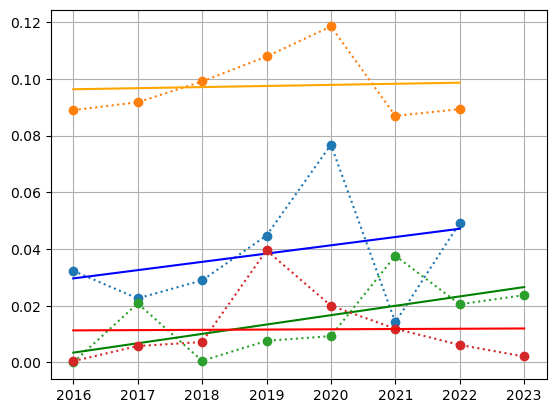

In [20]:
plt.plot(xtime_premon, RR_premon['RRhourly'].values, linestyle=':', marker= 'o', label='précipitations moyennes saisonnières')
plt.plot(xtime_premon, linRR_premon.intercept + linRR_premon.slope*xtime_premon, 'blue', label='fitted line')

plt.plot(xtime_mon, RR_mon['RRhourly'].values,linestyle=':', marker= 'o', label=' précipitations moyennes saisonnières')
plt.plot(xtime_mon, linRR_mon.intercept + linRR_mon.slope*xtime_mon, 'orange', label='fitted line')


plt.plot(xtime_postmon, RR_postmon['RRhourly'].values,linestyle=':', marker= 'o', label='précipitations moyennes saisonnières')
plt.plot(xtime_postmon, linRR_postmon.intercept + linRR_postmon.slope*xtime_postmon, 'green', label='fitted line')


plt.plot(xtime_hiver, RR_hiver['RRhourly'].values,linestyle=':', marker= 'o', label='précipitations moyennes saisonnières')
plt.plot(xtime_hiver, linRR_hiver.intercept + linRR_hiver.slope*xtime_hiver, 'r', label='fitted line')
plt.grid(True)

In [75]:
daily_meanRR2=RR.resample(time='D').sum()  
daily_meanRR3=RR.groupby('time.dayofyear').sum()  

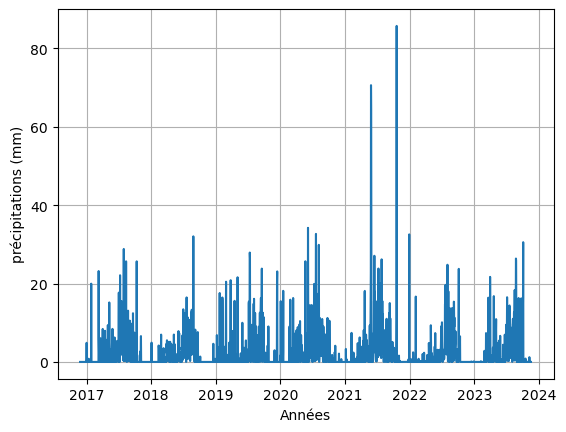

In [76]:
plt.plot(daily_meanRR2.time,daily_meanRR2['RRhourly'].values)
plt.title('')
plt.xlabel('Années')
plt.ylabel('précipitations (mm)')
plt.grid('true')

Text(0, 0.5, 'précipitations moyennes par jours (mm)')

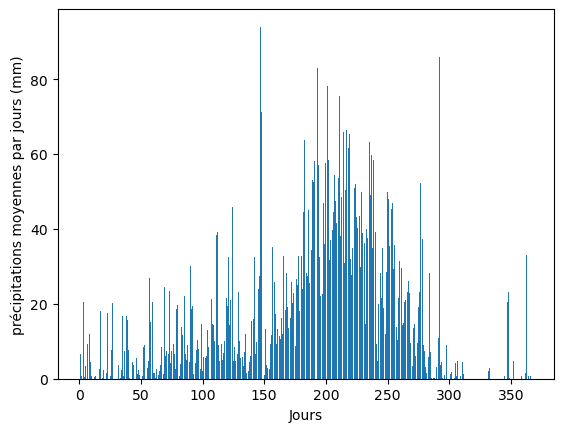

In [79]:
plt.bar(daily_meanRR3.dayofyear,daily_meanRR3['RRhourly'].values)
plt.title('')
plt.xlabel('Jours')
plt.ylabel('précipitations moyennes par jours (mm)')

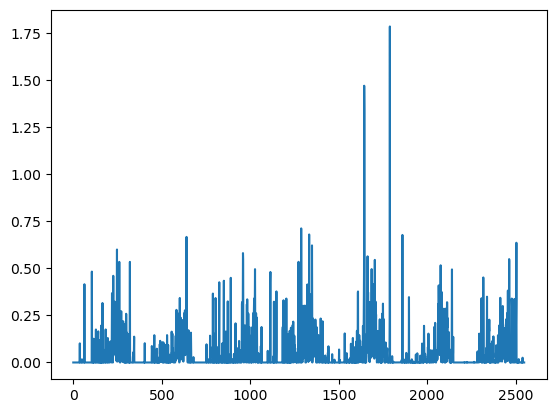

In [23]:
plt.plot(daily_meanRR['RRhourly'].values)